# Г2 Нейронные сети в 3D данных
    выполнил Сергей Харитонов МИВТ-221

# Задание
Задание творческое. По адресу https://drive.google.com/drive/folders/1BQQtdUAj9t0pWBN4rld8geKpv9sqv6Ik?usp=sharing лежат данные размеченные двумя классами и уже разбитые на тестовые и тренировочные. Применить нейронную сеть с указанной в варианте архитектурой и описать полученные результаты.


In [10]:
import os
from random import shuffle
import numpy as np
import tensorflow as tf
from keras import layers, regularizers, initializers, optimizers, Input, Model
from matplotlib import pyplot as plt
from keras.src.utils import model_to_dot
from IPython.core.display import SVG
%matplotlib inline

Загрузка облаков точек в память

In [2]:
DIR_PATH = os.getcwd()
DATA_PATH = os.path.join(DIR_PATH, 'data')


def load_data(entity: str, type_data: str) -> [[float]]:
    path = os.path.join(DATA_PATH, entity, type_data)
    files_paths = os.listdir(path)

    result = []
    for file_path in map(lambda file_path: os.path.join(path, file_path), files_paths):
        with open(file_path) as f:
            result.append(
                [
                    list(map(float, row.split()))[:3]
                    for row in f.readlines()
                ]
            )

    return result


bathtub_train = load_data('bathtub', 'train')
bathtub_test = load_data('bathtub', 'test')

berth_wall_train = load_data('berth_wall', 'train')
berth_wall_test = load_data('berth_wall', 'test')


Описание выборок для обучения и теста, а так же необходимых констант

In [3]:
# Размер скользящего окна по файлу с данными
NUM_POINTS = 2000
# Количество классов для классификации
NUM_CLASSES = 2


def get_data(data_rows: [[float]], flag: int):
    result = []
    for row in data_rows:
        while len(row) >= NUM_POINTS:
            result.append(row[:NUM_POINTS])
            row = row[NUM_POINTS:]
    if flag == 1:
        y = [1, 0]
    elif flag == 2:
        y = [0, 1]
    else:
        y = [0, 0]
    return [(np.array(row),  np.array(y)) for row in result]


train = get_data(bathtub_train, 1) + get_data(berth_wall_train, 2)
test = get_data(bathtub_test, 1) + get_data(berth_wall_test, 2)

shuffle(train)
shuffle(test)

train_x, train_y = list(zip(*train))
test_x, test_y = list(zip(*test))

def prepare_data(data):
    return np.array([
        np.array(image)
        for image in data
    ])


train_x, train_y = prepare_data(train_x), prepare_data(train_y)
test_x, test_y = prepare_data(test_x), prepare_data(test_y)


def print_stat(dataset, for_some):
    print(f'Образов для {for_some}: {len(dataset)}')
    print(f'Образов для {for_some} 1 типа bathtub: {len(list(filter(lambda row: row[1][0], dataset)))}')
    print(f'Образов для {for_some} 2 типа berthwall: {len(list(filter(lambda row: row[1][1], dataset)))}')


print_stat(train, 'обучения')
print()
print_stat(test, 'валидации')

Образов для обучения: 2672
Образов для обучения 1 типа bathtub: 392
Образов для обучения 2 типа berthwall: 2280

Образов для валидации: 675
Образов для валидации 1 типа bathtub: 167
Образов для валидации 2 типа berthwall: 508


Описание модели


In [7]:
def conv_bn(x, filters):
    x = layers.Conv1D(filters, kernel_size=1, padding="valid")(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)


def dense_bn(x, filters):
    x = layers.Dense(filters)(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)


class OrthogonalRegularizer(regularizers.Regularizer):
    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.eye = tf.eye(num_features)

    def __call__(self, x):
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tf.tensordot(x, x, axes=(2, 2))
        xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
        return tf.reduce_sum(self.l2reg * tf.square(xxt - self.eye))


def tnet(inputs, num_features):
    bias = initializers.Constant(np.eye(num_features).flatten())
    reg = OrthogonalRegularizer(num_features)

    x = conv_bn(inputs, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 256)
    x = dense_bn(x, 128)
    x = layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=bias,
        activity_regularizer=reg,
    )(x)
    feat_T = layers.Reshape((num_features, num_features))(x)
    return layers.Dot(axes=(2, 1))([inputs, feat_T])


inputs = Input(shape=(NUM_POINTS, 3))

x = tnet(inputs, 3)
x = conv_bn(x, 32)
x = conv_bn(x, 32)
x = tnet(x, 32)
x = conv_bn(x, 32)
x = conv_bn(x, 64)
x = conv_bn(x, 512)
x = layers.GlobalMaxPooling1D()(x)
x = dense_bn(x, 256)
x = layers.Dropout(0.3)(x)
x = dense_bn(x, 128)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = Model(inputs=inputs, outputs=outputs, name="pointnet")
print(model.summary())

Model: "pointnet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 2000, 3)]            0         []                            
                                                                                                  
 conv1d_11 (Conv1D)          (None, 2000, 32)             128       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_17 (Ba  (None, 2000, 32)             128       ['conv1d_11[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_17 (Activation)  (None, 2000, 32)             0         ['batch_normalization_1

Сборка модели и обучение

In [8]:
model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.legacy.Adam(),
    metrics=["categorical_accuracy"],
)


In [9]:
history = model.fit(
    train_x,
    train_y,
    epochs=10,
    batch_size=100,
    verbose=1,
    validation_data=(test_x, test_y)
)

Epoch 1/10
27/27 [==============================] - 108s 4s/step - loss: 5.3617 - categorical_accuracy: 0.9536 - val_loss: 3650.2480 - val_categorical_accuracy: 0.2474
Epoch 2/10
27/27 [==============================] - 107s 4s/step - loss: 3.5998 - categorical_accuracy: 1.0000 - val_loss: 12.9202 - val_categorical_accuracy: 0.2474
Epoch 3/10
27/27 [==============================] - 106s 4s/step - loss: 3.3688 - categorical_accuracy: 1.0000 - val_loss: 48.8062 - val_categorical_accuracy: 0.2474
Epoch 4/10
27/27 [==============================] - 108s 4s/step - loss: 3.3041 - categorical_accuracy: 1.0000 - val_loss: 3.2401 - val_categorical_accuracy: 1.0000
Epoch 5/10
27/27 [==============================] - 108s 4s/step - loss: 3.2969 - categorical_accuracy: 1.0000 - val_loss: 114.9870 - val_categorical_accuracy: 0.2474
Epoch 6/10
27/27 [==============================] - 107s 4s/step - loss: 3.2904 - categorical_accuracy: 1.0000 - val_loss: 3.2538 - val_categorical_accuracy: 1.0000
Epo

Визуализация процесса обучения

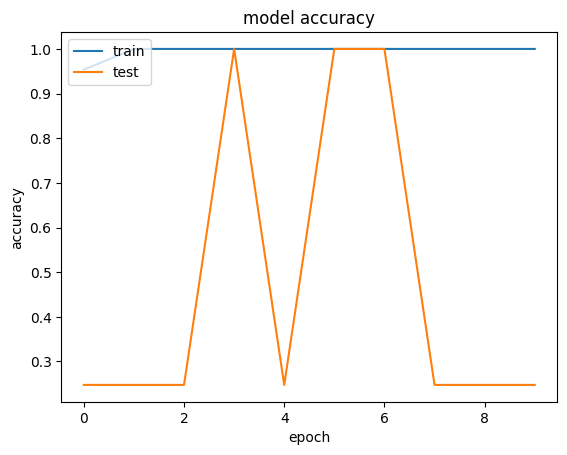

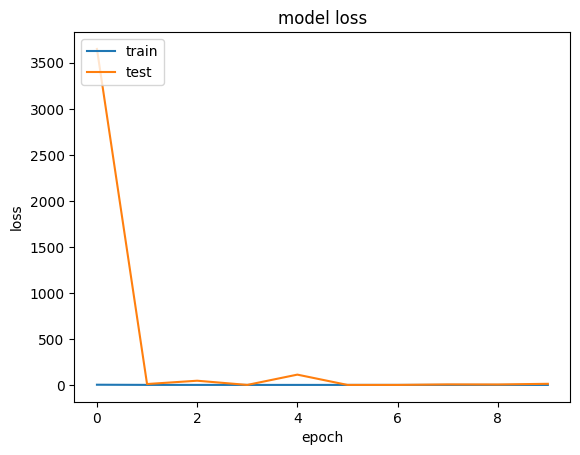

Итоговая точность на тренировочной выборке: 1.0
Итоговая точность на тестовой выборке: 0.24740740656852722
Итоговая ошибка на тренировочной выборке: 3.2937676906585693
Итоговая ошибка на тестовой выборке: 15.329201698303223


In [14]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title(f'model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(f'model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

print(f'Итоговая точность на тренировочной выборке: {history.history["categorical_accuracy"][-1]}')
print(f'Итоговая точность на тестовой выборке: {history.history["val_categorical_accuracy"][-1]}')
print(f'Итоговая ошибка на тренировочной выборке: {history.history["loss"][-1]}')
print(f'Итоговая ошибка на тестовой выборке: {history.history["val_loss"][-1]}')

Визуализация точек и их категоризации

1/1 [==============================] - 0s 70ms/step


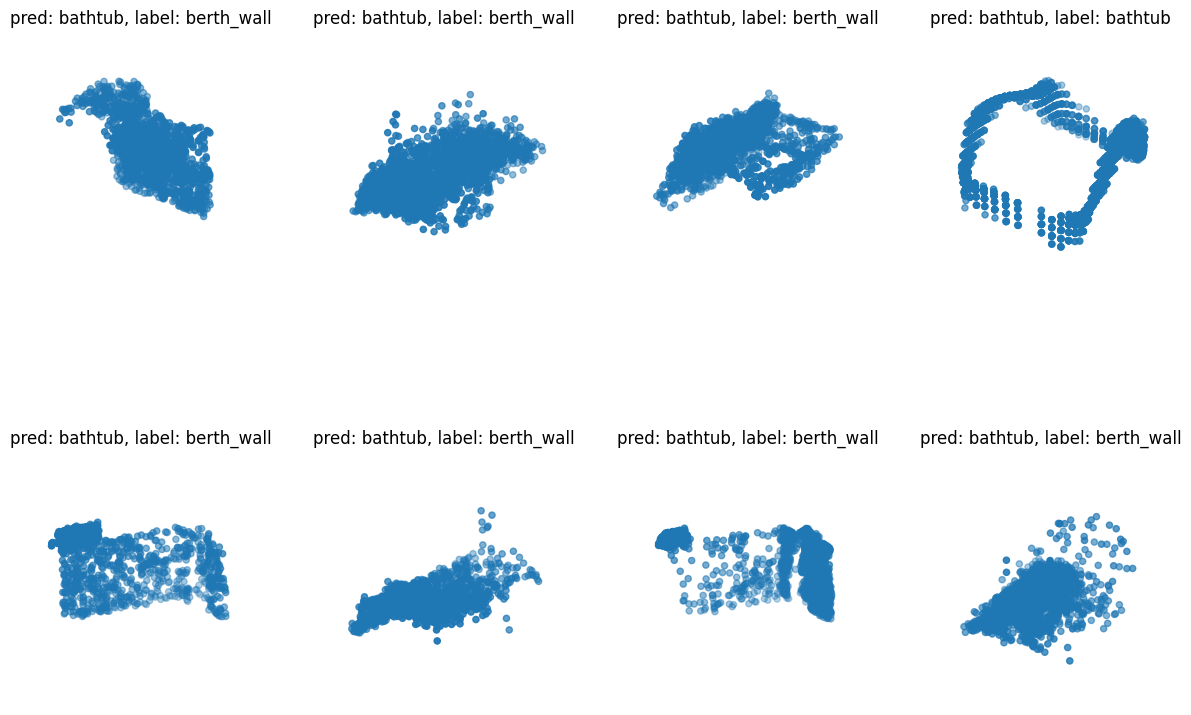

In [25]:
test_visualization = train[:8]
test_xv, test_yv = list(zip(*[
    (np.array(image[:NUM_POINTS]), flag)
    for image, flag in test_visualization
]))
predict_test_yv = model.predict(np.array(test_xv))

def get_name_class(y):
    if y[0] > y[1]:
        return 'bathtub'
    return 'berth_wall'

fig = plt.figure(figsize=(15, 10))
for i in range(8):
    ax = fig.add_subplot(2, 4, i + 1, projection="3d")
    points = list(zip(*test_xv[i]))
    ax.scatter(points[0], points[1], points[2])
    ax.set_title(
        "pred: {:}, label: {:}".format(
            get_name_class(predict_test_yv[i]), get_name_class(test_yv[i])
        )
    )
    ax.set_axis_off()
plt.show()

# Вывод
В ходе обучения сверточной сети были получены высокие результаты распознования
для цветных изображений - 99%
для чернобелых -98%

Так же было замечено, что время затрачиваемое на обучение на чернобелых изображений в десятки раз меньше при не значительной разнице в качестве распознавания
для цветных изображений - 0:04:07.880184
для чернобелых - 0:00:11.075703

